非定常ポアソン過程を実装する

方針
- データ生成過程をシミュレーションする

産地j, 時期tに関しては別々に扱う。

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import poisson


In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm


def generate_spatial_data(grid_size, length_scales, num_features, num_clusters, scales):
    """
    ガウス過程を用いて空間的な構造を持つ説明変数を生成する関数。
    
    Args:
        grid_size (int): グリッドの大きさ
        length_scales (list of float): RBFカーネルの長さスケール
        num_features (int): 特徴量の数
        num_clusters (int): クラスターの数
        scales (list of float): 特徴量ごとのスケール

    Returns:
        np.ndarray: 生成された空間データ
    """
    x = np.linspace(0, grid_size - 1, grid_size)
    y = np.linspace(0, grid_size - 1, grid_size)
    X_grid, Y_grid = np.meshgrid(x, y)
    coords = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    spatial_data = np.zeros((grid_size * grid_size, num_features))
    cluster_centers = np.random.rand(num_clusters, 2) * grid_size

    for i in range(num_features):
        for j in range(num_clusters):
            kernel = RBF(length_scale=length_scales[j % len(length_scales)])
            gp = GaussianProcessRegressor(kernel=kernel)
            cluster_data = gp.sample_y(coords, random_state=i * num_clusters + j).ravel()
            spatial_data[:, i] += cluster_data * norm.pdf(np.linalg.norm(coords - cluster_centers[j], axis=1), scale=length_scales[j % len(length_scales)]) * scales[i % len(scales)]

    return spatial_data.reshape(grid_size, grid_size, num_features)



In [3]:


def intensity(X, beta, alpha):
    return np.exp(np.sum(X * beta, axis=2) + alpha)


def simulate_poisson_process(grid_size, seed = None, verbose=False):

    # パラメータ設定
    length_scales = [10, 20, 30]  # 各クラスターの長さスケール
    num_features = 3
    num_clusters = 3
    scales_X = [1, 1, 1]  # 各特徴量に対する異なるスケール
    scales_beta = [-1, -1, -1]  # 各特徴量に対する異なるスケール

    # クラスターを持つ空間的な構造を持つ説明変数の生成
    X_true = generate_spatial_data(grid_size, length_scales, num_features, num_clusters, scales_X)
    X_true = (X_true - X_true.mean(axis=(0, 1))) / X_true.std(axis=(0, 1)) + 0.6

    # クラスターを持つ空間的な構造を持つ係数ベクトルの生成
    beta_true = generate_spatial_data(grid_size, length_scales, num_features, num_clusters, scales_beta)
    beta_true = (beta_true - beta_true.mean(axis=(0, 1))) / beta_true.std(axis=(0, 1)) -0.6

    alpha_true = -2
    
    if verbose:
        plt.figure(figsize=(12, 4))
        for i in range(num_features):
            plt.subplot(1, num_features, i+1)
            plt.title(f"Feature {i+1}")
            plt.imshow(X_true[:, :, i], cmap='hot', interpolation='nearest')
            plt.colorbar()
        plt.show()

    if verbose:
        plt.figure(figsize=(12, 4))
        for i in range(num_features):
            plt.subplot(1, num_features, i+1)
            plt.title(f"Beta {i+1}")
            plt.imshow(beta_true[:, :, i], cmap='hot', interpolation='nearest')
            plt.colorbar()
        plt.show()


    # ノイズの追加
    noise_level = 0.01
    X_true = X_true + np.random.normal(0, noise_level, X_true.shape)
    beta_true = beta_true + np.random.normal(0, noise_level, beta_true.shape)

    # 強度関数 λ(s) の計算
    
    lambda_true = intensity(X_true, beta_true, alpha_true)

    from scipy.stats import poisson

    # 領域全体の強度関数の積分 Λjt(D) を計算（離散化）
    D_area = grid_size * grid_size
    lambda_integral = np.sum(lambda_true)

    # 出土数 n1_jt を生成
    n_jt = poisson.rvs(lambda_integral)

    if verbose:
        print(f"Number of samples: {n_jt}")
    # 出土地点をサンプリング
    sampled_points = np.random.choice(D_area, size=n_jt, p=lambda_true.ravel() / lambda_integral)

    # 出土地点の座標に変換
    sampled_coords = np.unravel_index(sampled_points, (grid_size, grid_size))

    # 出土地点ごとのカウントを計算
    n_counts = np.zeros((grid_size, grid_size))
    for coord in zip(*sampled_coords):
        n_counts[coord] += 1

    if verbose:
        plt.figure(figsize=(6, 6))
        plt.title("True Intensity Function $\lambda(s)$")
        plt.imshow(lambda_true, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.title("Simulated Counts $n(s)$")
        plt.imshow(n_counts, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()
        
    return X_true, beta_true, lambda_true, n_counts, sampled_coords

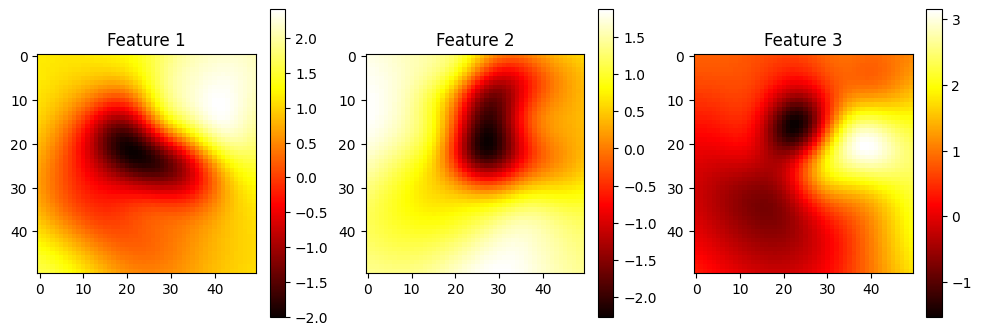

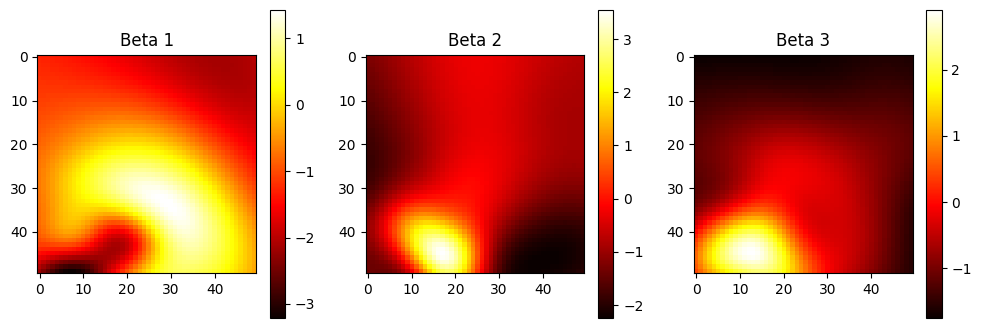

Number of samples: 293


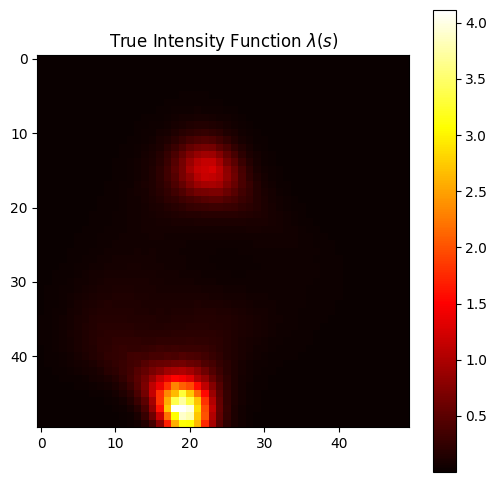

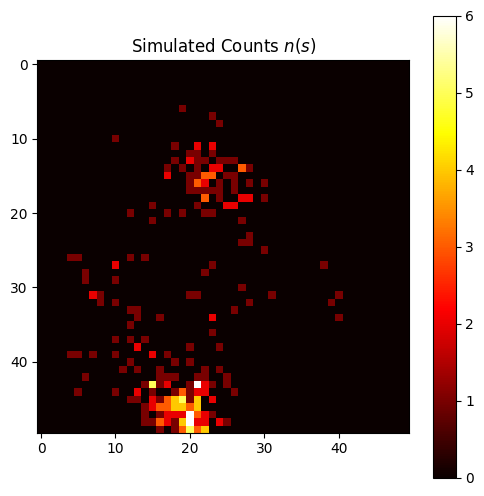

In [4]:
grid_size = 50

X_true, beta_true, lambda_true, n_counts, sampled_coords = simulate_poisson_process(grid_size, verbose=True)

# IPPを使った推定

## 偽不在データを生成

In [138]:
observed_coords

D_area.shape

(2315,)

In [140]:
import numpy as np

def generate_background_data(grid_size, observed_coords, num_background_points):
    """
    偽不在データを生成する関数。
    
    Args:
        grid_size (int): グリッドの大きさ
        observed_coords (ndarray): 観測された座標
        num_background_points (int): 偽不在データの数

    Returns:
        np.ndarray: 偽不在データのインデックス
    """
    D_area = grid_size * grid_size
    observed_points = np.ravel_multi_index(sampled_coords, (grid_size, grid_size))
    D_area_background = np.setdiff1d(np.arange(D_area), observed_points)
    background_points = np.random.choice(D_area_background, size=num_background_points, replace=False)
    return np.unravel_index(background_points, (grid_size, grid_size))


In [141]:
import numpy as np

def logistic(x):
    return 1 / (1 + np.exp(-x))

def weighted_likelihood(beta_observed, beta_background, X_observed, X_background, Z):
    """
    重み付き尤度関数を計算する関数。
    
    Args:
        beta (np.ndarray): モデルのパラメータ (n1 x d)
        beta_background (np.ndarray): 偽不在データのパラメータ (n0 x d)
        X_observed (np.ndarray): 観測データの説明変数 (n1 x d)
        X_background (np.ndarray): 偽不在データの説明変数
        Z (float): 偽不在データの重み

    Returns:
        float: 重み付き尤度
    """
    # 観測データ部分の尤度の計算
    linear_comb_observed = np.array([X_observed[i, :].dot(beta_observed[i, :]) for i in range(X_observed.shape[0])])
    observed_likelihood_terms = logistic(linear_comb_observed)
    observed_likelihood = np.prod(observed_likelihood_terms)

    # 偽不在データ部分の尤度の計算
    print(X_background.shape)
    linear_comb_background = np.array([X_background[i, :].dot(beta_background[i, :]) for i in range(X_background.shape[0])])
    background_likelihood_terms = logistic(-linear_comb_background) ** Z
    background_likelihood = np.prod(background_likelihood_terms)

    # 重み付き尤度の計算
    weighted_likelihood = observed_likelihood * background_likelihood
    return weighted_likelihood


# 観測データの設定
observed_coords = np.column_stack(sampled_coords)
X_observed = X_true[observed_coords[:, 0], observed_coords[:, 1]]

# パラメータの設定
num_background_points = 1000
Z = 10  # 偽不在データの重み

# 偽不在データの生成
background_coords = generate_background_data(grid_size, observed_coords, num_background_points)
background_coords = np.array(background_coords).T

# 偽不在データの説明変数を取得
X_background = X_true[background_coords[:, 0], background_coords[:, 1]]


# パラメータの設定
beta_observed = beta_true[observed_coords[:, 0], observed_coords[:, 1]]
beta_background = beta_true[background_coords[:, 0], background_coords[:, 1]]

# 重み付き尤度関数の計算
weighted_likelihood_value = weighted_likelihood(beta_observed, beta_background, X_observed, X_background, Z)
print(f"重み付き尤度関数の値: {weighted_likelihood_value}")


(1000, 3)
重み付き尤度関数の値: 0.0


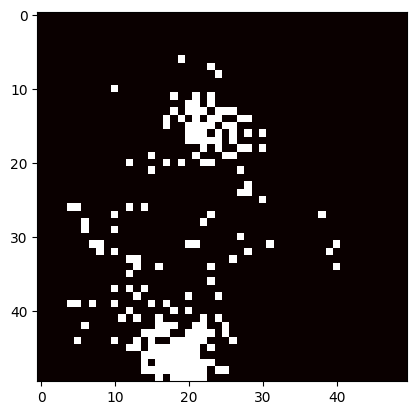

In [142]:
plot_data = np.zeros((grid_size, grid_size))
plot_data[observed_coords[:, 0], observed_coords[:, 1]] = 1
plt.imshow(plot_data, cmap='hot', interpolation='nearest')

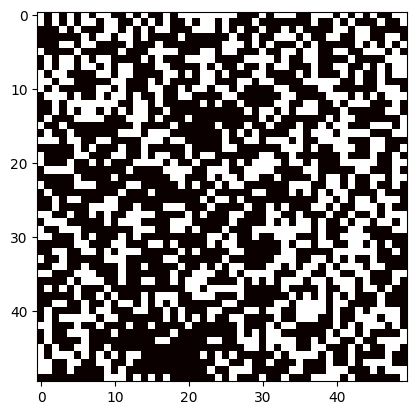

In [143]:
plot_data = np.zeros((grid_size, grid_size))
plot_data[background_coords[:, 0], background_coords[:, 1]] = 1
plt.imshow(plot_data, cmap='hot', interpolation='nearest')


Gibbsサンプリングを2つのパラメータで行うために、一方のパラメータを固定し、他方のパラメータを条件付きでサンプリングする操作を繰り返します。具体的には、まず$\beta$を初期化します。その後、$t = 1, \ldots, T$について次のようにサンプリングします。

$$
\Omega^{(t+1)} \sim p(\Omega \mid \beta^{(t)}) \\
\beta^{(t+1)} \sim p(\beta \mid \Omega^{(t+1)}).
$$

上記の各密度を計算できれば完了です。最初の密度は（8）から得られます。次のことがわかっています。

$$
\omega_n \mid \beta \sim \text{PG}(1, \beta^{\top} x_n).
$$

つまり、（13）を用いて$\Omega$の対角要素ごとにサンプリングします。2つ目の方程式は少し複雑です。もし$\beta$の事前分布が$\mathcal{N}(b, B)$であるなら、$p(\beta \mid \Omega, \mathbf{y})$は次のようになります。

$$
\beta \mid \Omega, \mathbf{y} \sim \mathcal{N}(m_\omega, V_\omega)
$$

ここで、

$$
V_\omega = (X^{\top} \Omega X + B^{-1})^{-1} \\
m_\omega = V_\omega (X^{\top} \kappa + B^{-1} b)
$$

$\kappa = \langle \kappa_1, \ldots, \kappa_N \rangle$です。この導出は、平方完成の行列式を使用し、少しの代数計算（A6参照）を必要とします。この導出をざっと確認して、$\beta$がガウス分布であるために機能する理由を確認する価値があります。

アルゴリズム的に考えると、$\omega_n$をサンプリングできるなら、この再パラメータ化を使用して、共分散が$X^{\top} \Omega X$の条件付きガウス尤度を$X^{-1} \Omega^{-1}$に中心に持つように得ることができます。


# サンプリングアルゴリズムの実装

In [144]:
import numpy as np
from scipy.stats import gamma
from scipy.stats import invgamma
from   pypolyagamma import PyPolyaGamma
from tqdm import tqdm

from typing import Tuple

## Utility functions

In [145]:
def create_uv_matrices(n, m):
    """
    (n*n)行列Kと、(m*m)の対角行列Bのクロネッカー積について、ブロック対角化するための行と列の入れ替え行列を作成
    """
    U = np.zeros((n*m, n*m))
    V = np.zeros((n*m, n*m))
    
    for i in range(n):
        for j in range(m):
            U[i*m + j, i + n*j] = 1
            V[i + n*j, i*m + j] = 1
    
    return U, V

def create_design_matrix(X_, L, D):
    """ 
    (L行D列)のデザイン行列X_から(L行L*D列)のデザイン行列Xを作成する。
    """
    X = np.zeros((L, L * D))
    for i in range(L):
        X[i, i * D:(i + 1) * D] = X_[i]
    return X

def multi_pgdraw(pg, B, C):
    """Utility function for calling `pgdraw` on every pair in vectors B, C.
    """
    return np.array([pg.pgdraw(b, c) for b, c in zip(B, C)])


def get_decomposition_matrix(cov: np.array) -> (Tuple, str):
    try:
        return np.linalg.cholesky(cov), "cholesky"
    except np.linalg.LinAlgError as e:
        return np.linalg.svd(cov), "SVD"

def sample_multivariate_normal(mean: np.array, decomposition_matrix: Tuple,
                               decomposition: str) -> np.array:
    if decomposition == "cholesky":
        standard_normal_vector = np.random.standard_normal(len(decomposition_matrix))
        return decomposition_matrix @ standard_normal_vector + mean
    elif decomposition == "SVD":
        u, s, vh = decomposition_matrix
        standard_normal_vector = np.random.standard_normal(len(u))
        return u @ np.diag(np.sqrt(s)) @ vh @ standard_normal_vector + mean

## 初期設定

In [146]:
# 初期設定

# データに関する変数の用意 =======================================================================

# design matrix Xを作成
X_ = np.vstack([X_observed, X_background])
X = create_design_matrix(X_, L, D)

D = X_true.shape[-1] # 特徴量次元

# カウント数z
z_observed = n_counts[observed_coords[:, 0], observed_coords[:, 1]]
z_background = np.ones(num_background_points) * Z
z = np.concatenate([z_observed, z_background])
z_hat = np.concatenate([z_observed, np.zeros(num_background_points)])

z = np.random.randn(L) # 偽不在データの重み TODO: あとで定義
s = np.vstack([observed_coords, background_coords]) # データの位置
L = n_counts.sum().astype(int) + num_background_points # データ数


# 固定パラメータ ===============================================================================

# phiの事前パラメータ
a0 = 2.0 
b0 = 1.0  

# vの事前分布のパラメータ
n0 = 3
s0 = 0.5

# lamdaの事前パラメータ
m0=2
r0=1


# 各種パラメータの初期値 =======================================================================

# Gaussian Kernelの特徴量内の分散phi (1, )
phi_0 = 0.5 

# 特徴量の係数beta (D*L, )
beta_0 = np.random.randn(D*L)

# Gaussian Kernelの特徴量間の分散v (1, )
v_0 = 0.2

# Bayesian Lassoの正則化パラメータtau (D, )
tau_0 = np.random.exponential(1/lamda, D)

# tau ~ Exp(lamda/2) のハイパーパラメータ (1,)
lamda_0 = 3

# Polya-Gamma分布に従う変数w (L, )
w_0 = np.random.randn(L)



### phiのMetropolis-Hastings sampler

TODO: たまにSimgaが非正則になってしまう。その場合はどういう対処が良いのかを後で検討する。

In [147]:
# 共分散行列がよく非正則になってしまう問題に対処するために、まずは対角成分にノイズを足してみた
def K(phi):
    """ 相関行列 K(phi) の計算 """
    #L*L
    dist_matrix = np.linalg.norm(s[:, np.newaxis, :] - s[np.newaxis, :, :], axis=2)
    K_matrix = np.exp(-phi * dist_matrix)
    K_matrix += np.eye(K_matrix.shape[0]) * 1e-10
    return K_matrix

def B_tau(tau):
    # D*D
    return np.diag(tau)

def Sigma_phi_tau(phi, tau, v):
    # (D*L)*(D*L)
    Sigma = np.kron(K(phi), B_tau(tau))
    return Sigma / v
    
def Sigma_phi_tau_inv(Sigma):
    # 入れ替え行列を作成
    U, V = create_uv_matrices(L, D)
    # 行と列を入れ替えた対角ブロック行列
    diag_block_matrix = U @ Sigma @ V
    
    # 各ブロックの逆行列を計算
    diag_block_inv = np.zeros_like(diag_block_matrix)
    for i in range(n):
        block = diag_block_matrix[i*m:(i+1)*m, i*m:(i+1)*m]
        block += np.eye(block.shape[0]) * 1e-10
        diag_block_inv[i*m:(i+1)*m, i*m:(i+1)*m] = np.linalg.inv(block)

    # 逆行列を元の形に戻す
    return V @ diag_block_inv @ U


def pi_phi(phi, beta, tau, v, a0, b0):
    Sigma = Sigma_phi_tau(phi, tau, v)
    inv_Sigma = Sigma_phi_tau_inv(Sigma)
    term1 = -np.log(np.linalg.det(Sigma))
    term2 = -0.5 * v * beta@inv_Sigma@beta
    term3 = (a0 - 1) * np.log(phi) - b0 * phi
    return term1 + term2 + term3

def sample_phi(phi_current, beta, tau, v, a0, b0):
    phi_proposal = gamma.rvs(phi_current, scale=1)
    
    # 提案分布の確率密度関数
    q_phi_current_given_proposal = gamma.pdf(phi_current, a=phi_proposal, scale=1)
    q_proposal_given_phi_current = gamma.pdf(phi_proposal, a=phi_current, scale=1)
    
    # 採択率の計算
    alpha = min(1, np.exp(
        pi_phi(phi_proposal, beta, tau, v, a0, b0) - pi_phi(phi_current, beta, tau, v, a0, b0)
        + np.log(q_phi_current_given_proposal) - np.log(q_proposal_given_phi_current)
    ))
    
    if np.random.rand() < alpha:
        return phi_proposal
    else:
        return phi_current

### beta, tau, v, lamda, wのGibbs Sampler

In [148]:

def sample_beta(X, w, v, phi, tau, z, z_hat):
    
    W = np.diag(w)    
    # Σ_betaの計算
    Sigma = Sigma_phi_tau(phi, tau, v)
    term = (-W + (1/v) * X @ Sigma @ X.T)
    term += np.eye(W.shape[0]) * 1e-10
    term = np.linalg.inv(term)
    Sigma_beta = (1/v)*Sigma - ((1/v)**2) * (Sigma @ X.T @ term @ X @ Sigma)
    Sigma_beta += np.eye(Sigma_beta.shape[0]) * 1e-8 # 多変量正規分布の安定性のため
    
    
    # kappa = (z_hat - z/2) / w で計算される変数kappa (L, )
    kappa = (z_hat - (z/2)) / w
    
    # tilde_betaの計算
    tilde_beta = Sigma_beta @ (X.T @ W @ kappa)
    
    # Cholesky分解を使用してβのサンプリング(多変量正規分布からのサンプリング)
    beta_sample = sample_multivariate_normal(tilde_beta, Sigma_beta, "cholesky")
    return beta_sample

def sample_tau(beta, phi, v, lamda):
    # 逆ガンマ分布からサンプルを生成

    beta_matrix = beta.reshape(D, L)
    tau_sample = np.zeros(D)
    
    for i in range(D):
        param_1 = np.sqrt(lamda * (1/v) * 1/(beta_matrix[i]@np.linalg.inv(K(phi))@beta_matrix[i]))
        param_2 = lamda
        tau_k_inv_sample = invgamma.rvs(a=param_1, scale=param_2)
        tau_sample[i] = 1 / tau_k_inv_sample
    return tau_sample

def sample_v(phi, beta, tau, v, n0, s0):

    # ガンマ分布のパラメータ
    param_1 = D*L/2 + n0/2 - 1
    
    Sig_inv = Sigma_phi_tau_inv(Sigma_phi_tau(phi, tau, v))
    param_2 = beta @ Sig_inv @ beta + s0

    # ガンマ分布からサンプルを生成
    # numpy.random.gammaはalphaと1/betaをパラメータにとることに注意
    return np.random.gamma(param_1, 1/param_2)

def sample_lamda(tau, m0, r0):
    # ガンマ分布のパラメータ
    alpha = D + m0 / 2
    beta_param = (np.sum(tau) + r0) / 2

    # ガンマ分布からサンプルを生成
    return np.random.gamma(alpha, 1 / beta_param)

def sample_w(z, X, beta):
    
    pg = PyPolyaGamma()
    return multi_pgdraw(pg, z, X@beta)


## サンプリングの実行

In [149]:
# シミュレーション回数
SIM = 10
t = 0

phi_list   = np.zeros((SIM))
beta_list  = np.zeros((SIM, beta_0.shape[0]))
tau_list   = np.zeros((SIM, tau_0.shape[0]))
v_list     = np.zeros((SIM))
lamda_list = np.zeros((SIM))
w_list     = np.zeros((SIM, w_0.shape[0]))

param_samples = {
    'phi': np.zeros((SIM)), 
    'beta': np.zeros((SIM, beta_0.shape[0])), 
    'tau': np.zeros((SIM, tau_0.shape[0])), 
    'v': np.zeros((SIM)), 
    'lamda': np.zeros((SIM)), 
    'w': np.zeros((SIM, w_0.shape[0]))
}

phi = phi_0
beta = beta_0
tau = tau_0
v = v_0
lamda = lamda_0
w = w_0
for t in tqdm(range(SIM)):
    
    phi   = sample_phi(phi, beta, tau, v, a0, b0)
    beta  = sample_beta(X, w, v, phi, tau, z, z_hat)
    print(beta)
    tau   = sample_tau(beta, phi, v, lamda)
    v     = sample_v(phi, beta, tau, v, n0, s0)
    lamda = sample_lamda(tau, m0, r0)
    w     = sample_w(z, X, beta)
    
    phi_list[t] = phi
    beta_list[t] = beta
    tau_list[t] = tau
    v_list[t] = v
    lamda_list[t] = lamda
    w_list[t] = w

    

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_377069/3884741237.py:39: RuntimeWarning: divide by zero encountered in log
  term1 = -np.log(np.linalg.det(Sigma))
/tmp/ipykernel_377069/3884741237.py:53: RuntimeWarning: invalid value encountered in scalar subtract
  pi_phi(phi_proposal, beta, tau, v, a0, b0) - pi_phi(phi_current, beta, tau, v, a0, b0)


[-1.71959956e+00 -4.43420893e+00 -1.26209766e+01 ...  8.87115211e-03
 -1.72535635e+00  1.55512311e+01]


/home/ohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4673: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0 / sc.gammainccinv(a, q)
 10%|█         | 1/10 [00:18<02:46, 18.46s/it]/tmp/ipykernel_377069/3907248887.py:14: RuntimeWarning: divide by zero encountered in divide
  kappa = (z_hat - (z/2)) / w
/tmp/ipykernel_377069/3907248887.py:17: RuntimeWarning: invalid value encountered in matmul
  tilde_beta = Sigma_beta @ (X.T @ W @ kappa)


[nan nan nan ... nan nan nan]


 10%|█         | 1/10 [00:25<03:46, 25.11s/it]


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.invgamma` documentation for details.